# Multi-view consistency tests

In [1]:
# Select you GPU
I_GPU = 0

# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
from PIL import Image
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker

from pykeops.torch import LazyTensor

import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)


MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


In [2]:
import os
import torchnet as tnt
import torch
from typing import Dict, Any
import wandb
from torch.utils.tensorboard import SummaryWriter
import logging
from torch_points3d.metrics.confusion_matrix import ConfusionMatrix
from torch_points3d.models import model_interface
from torch_points3d.metrics.base_tracker import BaseTracker, meter_value
from torch_points3d.metrics.meters import APMeter
from torch_points3d.datasets.segmentation import IGNORE_LABEL

from torch_geometric.nn.unpool import knn_interpolate
from torch_points3d.core.data_transform import SaveOriginalPosId

log = logging.getLogger(__name__)


def meter_value(meter, dim=0):
    return float(meter.value()[dim]) if meter.n > 0 else 0.0


class BaseTracker:
    def __init__(self, stage: str, wandb_log: bool, use_tensorboard: bool):
        self._wandb = wandb_log
        self._use_tensorboard = use_tensorboard
        self._tensorboard_dir = os.path.join(os.getcwd(), "tensorboard")
        self._n_iter = 0
        self._finalised = False
        self._conv_type = None

        if self._use_tensorboard:
            log.info(
                "Access tensorboard with the following command <tensorboard --logdir={}>".format(self._tensorboard_dir)
            )
            self._writer = SummaryWriter(log_dir=self._tensorboard_dir)

    def reset(self, stage="train"):
        self._stage = stage
        self._loss_meters = {}
        self._finalised = False

    def get_metrics(self, verbose=False) -> Dict[str, Any]:
        metrics = {}
        for key, loss_meter in self._loss_meters.items():
            value = meter_value(loss_meter, dim=0)
            if value:
                metrics[key] = meter_value(loss_meter, dim=0)
        return metrics

    @property
    def metric_func(self):
        self._metric_func = {"loss": min}
        return self._metric_func

    def track(self, model: model_interface.TrackerInterface, **kwargs):
        if self._finalised:
            raise RuntimeError("Cannot track new values with a finalised tracker, you need to reset it first")
            
        if model is not None:
            losses = self._convert(model.get_current_losses())
            self._append_losses(losses)

    def finalise(self, *args, **kwargs):
        """ Lifcycle method that is called at the end of an epoch. Use this to compute
        end of epoch metrics.
        """
        self._finalised = True

    def _append_losses(self, losses):
        for key, loss in losses.items():
            if loss is None:
                continue
            loss_key = "%s_%s" % (self._stage, key)
            if loss_key not in self._loss_meters:
                self._loss_meters[loss_key] = tnt.meter.AverageValueMeter()
            self._loss_meters[loss_key].add(loss)

    @staticmethod
    def _convert(x):
        if torch.is_tensor(x):
            return x.detach().cpu().numpy()
        else:
            return x

    def publish_to_tensorboard(self, metrics, step):
        for metric_name, metric_value in metrics.items():
            metric_name = "{}/{}".format(metric_name.replace(self._stage + "_", ""), self._stage)
            self._writer.add_scalar(metric_name, metric_value, step)

    @staticmethod
    def _remove_stage_from_metric_keys(stage, metrics):
        new_metrics = {}
        for metric_name, metric_value in metrics.items():
            new_metrics[metric_name.replace(stage + "_", "")] = metric_value
        return new_metrics

    def publish(self, step):
        """ Publishes the current metrics to wandb and tensorboard
        Arguments:
            step: current epoch
        """
        metrics = self.get_metrics()

        if self._wandb:
            wandb.log(metrics, step=step)

        if self._use_tensorboard:
            self.publish_to_tensorboard(metrics, step)

        # Some metrics may be intended for wandb or tensorboard
        # tracking but not for final final model selection. Those are
        # the metrics absent from self.metric_func and must be excluded
        # from the output of self.publish
        current_metrics = {
            k: v
            for k, v in self._remove_stage_from_metric_keys(self._stage, metrics).items()
            if k in self.metric_func.keys()}

        return {
            "stage": self._stage,
            "epoch": step,
            "current_metrics": current_metrics,
        }

    def print_summary(self):
        metrics = self.get_metrics(verbose=True)
        log.info("".join(["=" for i in range(50)]))
        for key, value in metrics.items():
            log.info("    {} = {}".format(key, value))
        log.info("".join(["=" for i in range(50)]))

    @staticmethod
    def _dict_to_str(dictionnary):
        string = "{"
        for key, value in dictionnary.items():
            string += "%s: %.2f," % (str(key), value)
        string += "}"
        return string


class SegmentationTracker(BaseTracker):
    def __init__(
        self, dataset, stage="train", wandb_log=False, use_tensorboard: bool = False, ignore_label: int = IGNORE_LABEL
    ):
        """ This is a generic tracker for multimodal tasks.
        It uses a confusion matrix in the back-end to track results.
        Use the tracker to track an epoch.
        You can use the reset function before you start a new epoch

        Arguments:
            dataset  -- dataset to track (used for the number of classes)

        Keyword Arguments:
            stage {str} -- current stage. (train, validation, test, etc...) (default: {"train"})
            wandb_log {str} --  Log using weight and biases
        """
        super(SegmentationTracker, self).__init__(stage, wandb_log, use_tensorboard)
        self._num_classes = dataset.num_classes
        self._ignore_label = ignore_label
        self._dataset = dataset
        self.reset(stage)
        self._metric_func = {
            "miou": max,
            "macc": max,
            "acc": max,
            "loss": min,
            "map": max,
        }  # Those map subsentences to their optimization functions

    def reset(self, stage="train"):
        super().reset(stage=stage)
        self._confusion_matrix = ConfusionMatrix(self._num_classes)
        self._acc = 0
        self._macc = 0
        self._miou = 0
        self._miou_per_class = {}

    @staticmethod
    def detach_tensor(tensor):
        if torch.torch.is_tensor(tensor):
            tensor = tensor.detach()
        return tensor

    @property
    def confusion_matrix(self):
        return self._confusion_matrix.confusion_matrix

    def track(self, model: model_interface.TrackerInterface, pred_labels=None, gt_labels=None, **kwargs):
        """ Add current model predictions (usually the result of a batch) to the tracking
        """
        if not self._dataset.has_labels(self._stage):
            return

        # Feng: to evaluate M2F predictions instead of model logits
        if pred_labels is not None and gt_labels is not None:
            outputs = pred_labels
            targets = gt_labels
        else:
            super().track(model)
            
            outputs = model.get_output()
            targets = model.get_labels()
        self._compute_metrics(outputs, targets)

    def _compute_metrics(self, outputs, labels):
        mask = labels != self._ignore_label
        outputs = outputs[mask]
        labels = labels[mask]

        outputs = self._convert(outputs)
        labels = self._convert(labels)

        if len(labels) == 0:
            return

        assert outputs.shape[0] == len(labels)
        
        # Check if output is predicted label or logits
        if len(outputs.shape) > 1:
            self._confusion_matrix.count_predicted_batch(labels, np.argmax(outputs, 1))
        else:
            
            self._confusion_matrix.count_predicted_batch(labels, outputs)

        self._acc = 100 * self._confusion_matrix.get_overall_accuracy()
        self._macc = 100 * self._confusion_matrix.get_mean_class_accuracy()
        self._miou = 100 * self._confusion_matrix.get_average_intersection_union()
        self._miou_per_class = {
            i: "{:.2f}".format(100 * v)
            for i, v in enumerate(self._confusion_matrix.get_intersection_union_per_class()[0])
        }

    def get_metrics(self, verbose=False) -> Dict[str, Any]:
        """ Returns a dictionnary of all metrics and losses being tracked
        """
        metrics = super().get_metrics(verbose)

        metrics["{}_acc".format(self._stage)] = self._acc
        metrics["{}_macc".format(self._stage)] = self._macc
        metrics["{}_miou".format(self._stage)] = self._miou

        if verbose:
            metrics["{}_miou_per_class".format(self._stage)] = self._miou_per_class
        return metrics

    @property
    def metric_func(self):
        return self._metric_func


class ScannetSegmentationTracker(SegmentationTracker):
    def reset(self, stage="train"):
        super().reset(stage=stage)
        self._full_confusion_matrix = ConfusionMatrix(self._num_classes)
        self._raw_datas = {}
        self._votes = {}
        self._vote_counts = {}
        self._full_preds = {}
        self._full_acc = None

    def track(self, model: model_interface.TrackerInterface, full_res=False, pred_labels=None, gt_labels=None, **kwargs):
        """ Add current model predictions (usually the result of a batch) to the tracking
        """
        if pred_labels is not None and gt_labels is not None:
            super().track(model=None, pred_labels=pred_labels, gt_labels=gt_labels)
        else:
            super().track(model)

            # Set conv type
            self._conv_type = model.conv_type

            # Train mode or low res, nothing special to do
            if not full_res or self._stage == "train" or kwargs.get("data") is None:
                return

            data = kwargs.get("data", model.get_input())
            data = data.data if model.is_multimodal else data
            self._vote(data, model.get_output())

    def get_metrics(self, verbose=False) -> Dict[str, Any]:
        """ Returns a dictionnary of all metrics and losses being tracked
        """
        metrics = super().get_metrics(verbose)
        if self._full_acc:
            metrics["{}_full_acc".format(self._stage)] = self._full_acc
            metrics["{}_full_macc".format(self._stage)] = self._full_macc
            metrics["{}_full_miou".format(self._stage)] = self._full_miou
        return metrics

    def finalise(self, full_res=False, make_submission=False, **kwargs):
        if not full_res and not make_submission:
            return
        
        self._predict_full_res()

        # Compute full res metrics
        if self._dataset.has_labels(self._stage):
            for scan_id in self._full_preds:
                full_labels = self._raw_datas[scan_id].y
                # Mask ignored labels
                mask = full_labels != self._ignore_label
                full_labels = full_labels[mask]
                full_preds = self._full_preds[scan_id].cpu()[mask].numpy()
                self._full_confusion_matrix.count_predicted_batch(full_labels, full_preds)

            self._full_acc = 100 * self._full_confusion_matrix.get_overall_accuracy()
            self._full_macc = 100 * self._full_confusion_matrix.get_mean_class_accuracy()
            self._full_miou = 100 * self._full_confusion_matrix.get_average_intersection_union()
            
        # Save files to disk
        if make_submission and self._stage == "test":
            self._make_submission()

    def _make_submission(self):
        orginal_class_ids = np.asarray(self._dataset.train_dataset.valid_class_idx)
        path_to_submission = self._dataset.path_to_submission
        for scan_id in self._full_preds:
            full_pred = self._full_preds[scan_id].cpu().numpy().astype(np.int8)
            full_pred = orginal_class_ids[full_pred]  # remap labels to original labels between 0 and 40
            scan_name = self._raw_datas[scan_id].scan_name
            path_file = osp.join(path_to_submission, "{}.txt".format(scan_name))
            np.savetxt(path_file, full_pred, delimiter="/n", fmt="%d")

    def _vote(self, data, output):
        """ Populates scores for the points in data

        Parameters
        ----------
        data : Data
            should contain `pos` and `SaveOriginalPosId.KEY` keys
        output : torch.Tensor
            probablities out of the model, shape: [N,nb_classes]
        """
        id_scans = data.id_scan
        if id_scans.dim() > 1:
            id_scans = id_scans.squeeze()
        if self._conv_type == "DENSE":
            batch_size = len(id_scans)
            output = output.view(batch_size, -1, output.shape[-1])

        for idx_batch, id_scan in enumerate(id_scans):
            # First time we see this scan
            if id_scan not in self._raw_datas:
                raw_data = self._dataset.get_raw_data(self._stage, id_scan, remap_labels=True)
                self._raw_datas[id_scan] = raw_data
                self._vote_counts[id_scan] = torch.zeros(raw_data.pos.shape[0], dtype=torch.int)
                self._votes[id_scan] = torch.zeros((raw_data.pos.shape[0], self._num_classes), dtype=torch.float)
            else:
                raw_data = self._raw_datas[id_scan]

            batch_mask = idx_batch
            if self._conv_type != "DENSE":
                batch_mask = data.batch == idx_batch
            idx = data[SaveOriginalPosId.KEY][batch_mask]

            self._votes[id_scan][idx] += output[batch_mask].cpu()
            self._vote_counts[id_scan][idx] += 1

    def _predict_full_res(self):
        """ Predict full resolution results based on votes """
        for id_scan in self._votes:
            has_prediction = self._vote_counts[id_scan] > 0
            self._votes[id_scan][has_prediction] /= self._vote_counts[id_scan][has_prediction].unsqueeze(-1)

            # Upsample and predict
            full_pred = knn_interpolate(
                self._votes[id_scan][has_prediction],
                self._raw_datas[id_scan].pos[has_prediction],
                self._raw_datas[id_scan].pos,
                k=1,
            )
            self._full_preds[id_scan] = full_pred.argmax(-1)


In [3]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small_6views'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks

In [4]:
# cfg.data.center_xy = True
# cfg.data.center_z = True
# cfg.data.multimodal.val_transforms[2].params.n_img = 25
# cfg.data.undo_axis_align = True

In [5]:
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = 6 #cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

6


In [6]:
# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)
print(f"Time = {time() - start:0.1f} sec.")

Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 7.7 sec.


In [7]:
# picture, toilet, sink
# 10: '37.40' , 16: '93.46', 17: '72.64'
# 10: '35.78' , 16: '86.91', 17: '69.42'
# Check confusion matrix changes to investigate error types!


In [8]:
from torch_points3d.models.model_factory import instantiate_model

# Set your parameters
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2022-12-07/12-07-34' # 3rd run
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run'

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)

# Load the checkpoint and recover the model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['latest'], strict=False)

# Prepare the model for inference
model = model.eval().cuda()
print('Model loaded')

Creating model: MVFusion_3D_small_6views
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small_6views
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Model loaded


### Confusion matrix

In [35]:
from torch_points3d.utils.multimodal import lexargsort
from torch_points3d.core.multimodal.csr import CSRData
import scipy.ndimage
import matplotlib.pyplot as plt
import seaborn as sns
    
tracker_mvfusion = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker_mvfusion_2d = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker_m2f = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker_m2f_2d = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)


In [38]:



for sample_idx in range(0, 300, 10):
    # Track each sample
    tracker_m2f.reset(stage='train')
    tracker_mvfusion.reset(stage='train')
    
    all_classes = np.arange(20)
    # Add 1 of each class
    tracker_m2f.track(pred_labels=all_classes, gt_labels=all_classes, model=None)
    tracker_mvfusion.track(pred_labels=all_classes, gt_labels=all_classes, model=None)    
    
    
    mm_data = dataset.val_dataset[sample_idx]
    
    # Create a MMBatch and run inference
    batch = MMBatch.from_mm_data_list([mm_data])

    with torch.no_grad():
        model.set_input(batch, model.device)
        model(batch)

    # Recover the predicted labels for visualization
    mm_data.data.pred = model.output.detach().cpu().argmax(1)
    
    mm_data = get_seen_points(mm_data)

    m2f_mode_preds = get_mode_pred(mm_data)
   
    tracker_m2f.track(pred_labels=m2f_mode_preds, gt_labels=mm_data.data.y, model=None)
    tracker_mvfusion.track(pred_labels=mm_data.data.pred, gt_labels=mm_data.data.y, model=None)

    print("scan idx: ", sample_idx)
    print("Input Mask mode pred: ", tracker_m2f.get_metrics())
    print("MVFusion 3D mIoU: ", tracker_mvfusion.get_metrics())



scan idx:  0
Input Mask mode pred:  {'train_acc': 91.74158253038894, 'train_macc': 93.93296618066863, 'train_miou': 78.28548078105783}
MVFusion 3D mIoU:  {'train_acc': 96.20733637606995, 'train_macc': 97.17205186578879, 'train_miou': 88.69265731878926}
scan idx:  10
Input Mask mode pred:  {'train_acc': 95.00947891581698, 'train_macc': 97.92131109172814, 'train_miou': 81.60509264591045}
MVFusion 3D mIoU:  {'train_acc': 98.51240798620007, 'train_macc': 99.20943950104298, 'train_miou': 98.5987458226053}
scan idx:  20
Input Mask mode pred:  {'train_acc': 95.07710557532621, 'train_macc': 94.81272111981657, 'train_miou': 78.40669891749008}
MVFusion 3D mIoU:  {'train_acc': 97.75800711743771, 'train_macc': 97.08475240627969, 'train_miou': 89.19332424035187}
scan idx:  30
Input Mask mode pred:  {'train_acc': 95.19883761331691, 'train_macc': 96.80013048090859, 'train_miou': 85.31466747978384}
MVFusion 3D mIoU:  {'train_acc': 96.74658075112922, 'train_macc': 99.06303705103299, 'train_miou': 93.67

In [7]:
# def save_confusion_matrix(cm, path2save, ordered_names):
#     sns.set(font_scale=5)

#     template_path = os.path.join(path2save, "{}.png")
#     # PRECISION
#     cmn = cm.astype("float") / cm.sum(axis=-1)[:, np.newaxis]
#     cmn[np.isnan(cmn) | np.isinf(cmn)] = 0
#     fig, ax = plt.subplots(figsize=(31, 31))
#     sns.heatmap(
#         cmn, annot=True, fmt=".2f", xticklabels=ordered_names, yticklabels=ordered_names, annot_kws={"size": 20}
#     )
#     # g.set_xticklabels(g.get_xticklabels(), rotation = 35, fontsize = 20)
#     plt.ylabel("Actual")
#     plt.xlabel("Predicted")
#     path_precision = template_path.format("precision")
#     plt.tight_layout()
#     plt.savefig(path_precision, format="png")

#     # RECALL
#     cmn = cm.astype("float") / cm.sum(axis=0)[np.newaxis, :]
#     cmn[np.isnan(cmn) | np.isinf(cmn)] = 0
#     fig, ax = plt.subplots(figsize=(31, 31))
#     sns.heatmap(
#         cmn, annot=True, fmt=".2f", xticklabels=ordered_names, yticklabels=ordered_names, annot_kws={"size": 20}
#     )
#     # g.set_xticklabels(g.get_xticklabels(), rotation = 35, fontsize = 20)
#     plt.ylabel("Actual")
#     plt.xlabel("Predicted")
#     path_recall = template_path.format("recall")
#     plt.tight_layout()
#     plt.savefig(path_recall, format="png")

# confusion_m_dir = "/home/fsun/DeepViewAgg/notebooks/confusion_matrix/mvfusion_2d"
# os.makedirs(confusion_m_dir, exist_ok=True)
# save_confusion_matrix(tracker_mvfusion_2d._confusion_matrix.confusion_matrix, path2save=confusion_m_dir, ordered_names=CLASS_LABELS)

# Result Analysis

In [65]:
m2f_scores = """85.7 91.2 66.9 82.4 77.1 72.7 78.4 65.6 62.0 73.9 47.1 60.0 63.2 73.0 71.4 74.5 92.5 71.8 83.5 55.2
87.4 92.0 72.0 84.5 81.8 79.4 81.3 72.4 65.8 77.4 52.1 66.2 68.8 80.1 78.9 78.1 86.9 69.1 85.5 60.3"""
vit_scores = """86.9 91.8 68.2 84.6 80.0 76.2 79.8 73.9 69.6 74.2 36.1 58.3 68.4 73.5 78.4 76.4 93.5 73.3 85.4 60.0
87.4 92.1 73.5 85.1 83.6 82.4 81.3 79.3 73.2 77.9 35.2 64.2 72.8 79.6 85.5 79.6 87.3 70.3 86.0 63.0"""

m2f_dict = {}
m2f_refined_dict = {}

vit_dict = {}
vit_refined_dict = {}

scores_list = [m2f_scores, vit_scores]
for i in range(len(scores_list)):
    scores_list[i] = [s.split(" ") for s in [l.strip() for l in scores_list[i].split("\n")]]
    
    for j, name in enumerate(CLASS_LABELS):
        if i == 0:
            m2f_dict[name] = float(scores_list[i][0][j])
            m2f_refined_dict[name] = float(scores_list[i][1][j])
        else:
            vit_dict[name] = float(scores_list[i][0][j])
            vit_refined_dict[name] = float(scores_list[i][1][j])
            
            
print(m2f_dict)
print(m2f_refined_dict)

print(vit_dict)
print(vit_refined_dict)

{'wall': 85.7, 'floor': 91.2, 'cabinet': 66.9, 'bed': 82.4, 'chair': 77.1, 'sofa': 72.7, 'table': 78.4, 'door': 65.6, 'window': 62.0, 'bookshelf': 73.9, 'picture': 47.1, 'counter': 60.0, 'desk': 63.2, 'curtain': 73.0, 'refrigerator': 71.4, 'shower curtain': 74.5, 'toilet': 92.5, 'sink': 71.8, 'bathtub': 83.5, 'otherfurniture': 55.2}
{'wall': 87.4, 'floor': 92.0, 'cabinet': 72.0, 'bed': 84.5, 'chair': 81.8, 'sofa': 79.4, 'table': 81.3, 'door': 72.4, 'window': 65.8, 'bookshelf': 77.4, 'picture': 52.1, 'counter': 66.2, 'desk': 68.8, 'curtain': 80.1, 'refrigerator': 78.9, 'shower curtain': 78.1, 'toilet': 86.9, 'sink': 69.1, 'bathtub': 85.5, 'otherfurniture': 60.3}
{'wall': 86.9, 'floor': 91.8, 'cabinet': 68.2, 'bed': 84.6, 'chair': 80.0, 'sofa': 76.2, 'table': 79.8, 'door': 73.9, 'window': 69.6, 'bookshelf': 74.2, 'picture': 36.1, 'counter': 58.3, 'desk': 68.4, 'curtain': 73.5, 'refrigerator': 78.4, 'shower curtain': 76.4, 'toilet': 93.5, 'sink': 73.3, 'bathtub': 85.4, 'otherfurniture': 6

In [67]:
class_freq = {
# ignored : 24.95166015625,
'wall' : 23.9874210357666,
'floor' : 18.313692092895508,
'cabinet' : 3.2387654781341553,
'bed' : 2.1580026149749756,
'chair' : 5.742490291595459,
'sofa' : 1.9507580995559692,
'table' : 2.8225202560424805,
'door' : 3.610508918762207,
'window' : 3.1121556758880615,
'bookshelf' : 1.888633131980896,
'picture' : 0.3890889585018158,
'counter' : 0.3829375207424164,
'desk' : 1.5345507860183716,
'curtain' : 1.7276479005813599,
'refrigerator' : 0.4140370190143585,
'shower curtain' : 0.2509376108646393,
'toilet' : 0.24982835352420807,
'sink' : 0.20596717298030853,
'bathtub' : 0.27245980501174927,
'otherfurniture' : 2.79593563079834
}

In [68]:
# Percentual change
# Absolute change
# Class frequency

key_order = list(m2f_dict.keys())

sorted_order = np.argsort(list(class_freq.values()))[::-1]
key_order = [key_order[i] for i in sorted_order]

print(f" freq  | {'class':{15}} | m2f  +    | vit  +    | change |  rel_change")
print("---------------------------------------------")
for k in key_order:
    change = np.round(( (m2f_refined_dict[k] - m2f_dict[k]) + (vit_refined_dict[k] - vit_dict[k]) ) / 2, 1)
    rel_change = ( ((m2f_refined_dict[k]-m2f_dict[k]) / m2f_dict[k]) + ((vit_refined_dict[k]-vit_dict[k]) / vit_dict[k]) ) / 2 * 100
    rel_change = np.round(rel_change, 1)
    print(f" {np.round(class_freq[k], 2):{5}} | {k:{15}} | {m2f_dict[k]} {m2f_refined_dict[k]} | {vit_dict[k]} {vit_refined_dict[k]} |{change:{4}}    | {rel_change:{4}}")

 freq  | class           | m2f  +    | vit  +    | change |  rel_change
---------------------------------------------
 23.99 | wall            | 85.7 87.4 | 86.9 87.4 | 1.1    |  1.3
 18.31 | floor           | 91.2 92.0 | 91.8 92.1 | 0.5    |  0.6
  5.74 | chair           | 77.1 81.8 | 80.0 83.6 | 4.1    |  5.3
  3.61 | door            | 65.6 72.4 | 73.9 79.3 | 6.1    |  8.8
  3.24 | cabinet         | 66.9 72.0 | 68.2 73.5 | 5.2    |  7.7
  3.11 | window          | 62.0 65.8 | 69.6 73.2 | 3.7    |  5.7
  2.82 | table           | 78.4 81.3 | 79.8 81.3 | 2.2    |  2.8
   2.8 | otherfurniture  | 55.2 60.3 | 60.0 63.0 | 4.0    |  7.1
  2.16 | bed             | 82.4 84.5 | 84.6 85.1 | 1.3    |  1.6
  1.95 | sofa            | 72.7 79.4 | 76.2 82.4 | 6.5    |  8.7
  1.89 | bookshelf       | 73.9 77.4 | 74.2 77.9 | 3.6    |  4.9
  1.73 | curtain         | 73.0 80.1 | 73.5 79.6 | 6.6    |  9.0
  1.53 | desk            | 63.2 68.8 | 68.4 72.8 | 5.0    |  7.6
  0.41 | refrigerator    | 71.4 78.9 

In [69]:
import pandas as pd

df = pd.DataFrame(list(zip(class_freq.values(), CLASS_LABELS, m2f_dict.values(), m2f_refined_dict.values(), vit_dict.values(), vit_refined_dict.values())),
               columns =['freq', 'class', 'm2f', 'm2f_ref', 'vit', 'vit_ref'])
df['mean_change'] = np.round(( (df['m2f_ref'] - df['m2f']) + (df['vit_ref'] - df['vit']) ) / 2, 1)
df['mean_rel_change'] = np.round( ( ((df['m2f_ref']-df['m2f']) / df['m2f']) + ((df['vit_ref']-df['vit']) / df['vit']) ) / 2 * 100, 1)

df['m2f_change'] = np.round(df['m2f_ref'] - df['m2f'], 1)

df['vit_change'] = np.round(df['vit_ref'] - df['vit'], 1)

df.sort_values(by=['m2f'], ascending=False)

,freq,class,m2f,m2f_ref,vit,vit_ref,mean_change,mean_rel_change,m2f_change,vit_change
16,0.249828,toilet,92.5,86.9,93.5,87.3,-5.9,-6.3,-5.6,-6.2
1,18.313692,floor,91.2,92.0,91.8,92.1,0.5,0.6,0.8,0.3
0,23.987421,wall,85.7,87.4,86.9,87.4,1.1,1.3,1.7,0.5
18,0.272460,bathtub,83.5,85.5,85.4,86.0,1.3,1.5,2.0,0.6
3,2.158003,bed,82.4,84.5,84.6,85.1,1.3,1.6,2.1,0.5
6,2.822520,table,78.4,81.3,79.8,81.3,2.2,2.8,2.9,1.5
4,5.742490,chair,77.1,81.8,80.0,83.6,4.1,5.3,4.7,3.6
15,0.250938,shower curtain,74.5,78.1,76.4,79.6,3.4,4.5,3.6,3.2
9,1.888633,bookshelf,73.9,77.4,74.2,77.9,3.6,4.9,3.5,3.7
13,1.727648,curtain,73.0,80.1,73.5,79.6,6.6,9.0,7.1,6.1


In [79]:
sorted_df = df.sort_values(by=['mean_change'], ascending=False)
sorted_df

,freq,class,m2f,m2f_ref,vit,vit_ref,mean_change,mean_rel_change,m2f_change,vit_change
14,0.414037,refrigerator,71.4,78.9,78.4,85.5,7.3,9.8,7.5,7.1
13,1.727648,curtain,73.0,80.1,73.5,79.6,6.6,9.0,7.1,6.1
5,1.950758,sofa,72.7,79.4,76.2,82.4,6.5,8.7,6.7,6.2
7,3.610509,door,65.6,72.4,73.9,79.3,6.1,8.8,6.8,5.4
11,0.382938,counter,60.0,66.2,58.3,64.2,6.1,10.2,6.2,5.9
2,3.238765,cabinet,66.9,72.0,68.2,73.5,5.2,7.7,5.1,5.3
12,1.534551,desk,63.2,68.8,68.4,72.8,5.0,7.6,5.6,4.4
4,5.742490,chair,77.1,81.8,80.0,83.6,4.1,5.3,4.7,3.6
19,2.795936,otherfurniture,55.2,60.3,60.0,63.0,4.0,7.1,5.1,3.0
8,3.112156,window,62.0,65.8,69.6,73.2,3.7,5.7,3.8,3.6


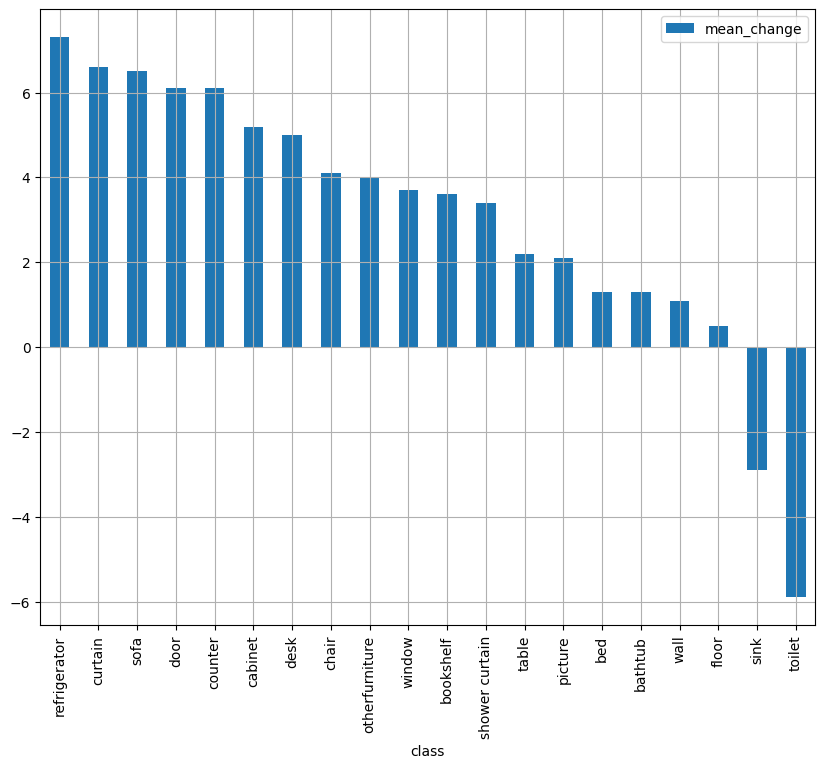

In [80]:
ax = sorted_df.plot.bar(x='class', y='mean_change', rot=90, figsize=(10, 8), grid=True)

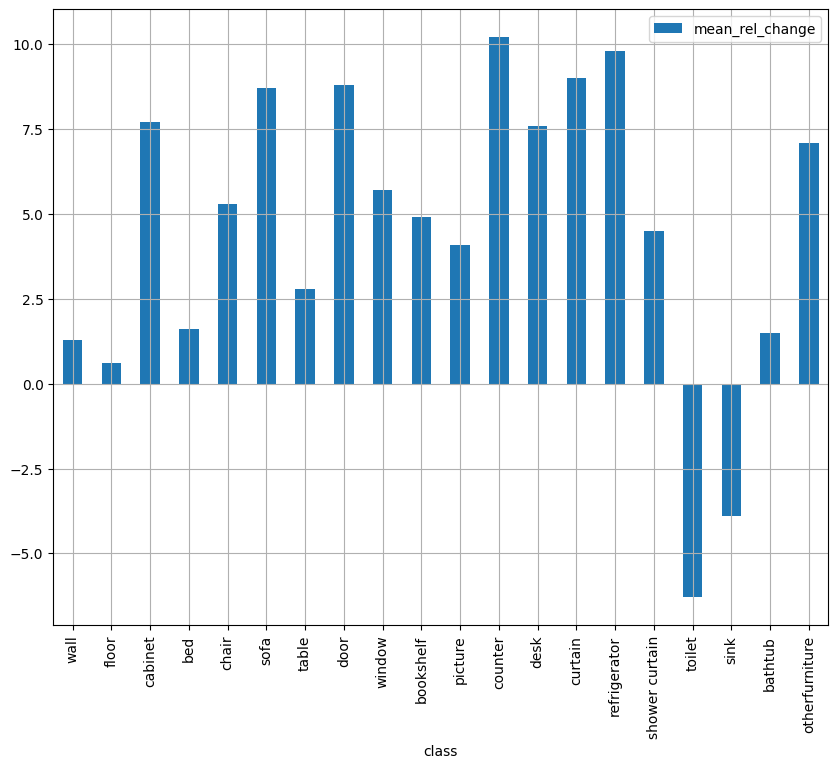

In [72]:
ax = df.plot.bar(x='class', y='mean_rel_change', rot=90, figsize=(10, 8), grid=True)

### Class frequencies

In [37]:
def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    
    return mm_data


def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds


### Visualizations
Scan 220 (Errors from illumination and class ambiguity)
- Falsely classified refridgerator on the floor, and significant ambiguity between chair and sofa causes messy prediction.
- Refinement recovers both errors

In [89]:
scan_id_to_name = getattr(
    dataset.val_dataset, f"MAPPING_IDX_TO_SCAN_VAL_NAMES")
scan_id_to_name[idx]     

'scene0351_01'

In [ ]:
idx = 32

mm_data = dataset.val_dataset[idx] 

m2f_mm_data = get_seen_points(mm_data.clone())
mode_preds = get_mode_pred(m2f_mm_data)

m2f_mm_data.data.x = None
m2f_mm_data.data.pred = mode_preds
m2f_mm_data.data.pred = m2f_mm_data.data.pred[m2f_mm_data.data.y != -1]
m2f_mm_data = m2f_mm_data[m2f_mm_data.data.y != -1]

visualize_mm_data(m2f_mm_data, draw_image_positions=False, figsize=900, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)



In [ ]:
# Create a MMBatch and run inference
batch = MMBatch.from_mm_data_list([mm_data])

with torch.no_grad():
    model.set_input(batch, model.device)
    model(batch)

# Recover the predicted labels for visualization
mm_data.data.pred = model.output.detach().cpu().argmax(1)
mm_data.data.pred = mm_data.data.pred[mm_data.data.y != -1]
mm_data = mm_data[mm_data.data.y != -1]
    
visualize_mm_data(get_seen_points(mm_data), draw_image_positions=False, figsize=900, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)